In [97]:
with open('./data/human_names.txt') as f:
    words = f.read().splitlines()

words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [104]:
import torch
import itertools

START, END = '.', '.'

words = [START+w+END for w in words]

chars_index = {c: i for i, c in enumerate(sorted(set(itertools.chain(*words))))}
chars_index_inverted = {i: c for c, i in chars_index.items()}

grams = sorted(c1+c2 for w in words for c1, c2 in zip(w, w[1:]))
grams_index = {c: i for i, c in enumerate([*sorted(set(grams))]) }
grams_index_inverted = {i: c for c, i in grams_index.items()}

N = torch.zeros(len(grams_index), len(words_index), dtype=torch.int32)
N.shape

pairs = []
for w in words:
    for c1 ,c2, c3 in zip(w, w[1:], w[2:]):
        g = c1+c2
        if c1 == END and c2 == END and c3 == END:
            continue
        pairs.append((g, c3))
        N[grams_index[g], chars_index[c3]] += 1


# print(len(pairs))
pairs[:20]

[('..', 'e'),
 ('.e', 'm'),
 ('em', 'm'),
 ('mm', 'a'),
 ('ma', '.'),
 ('a.', '.'),
 ('..', 'o'),
 ('.o', 'l'),
 ('ol', 'i'),
 ('li', 'v'),
 ('iv', 'i'),
 ('vi', 'a'),
 ('ia', '.'),
 ('a.', '.'),
 ('..', 'a'),
 ('.a', 'v'),
 ('av', 'a'),
 ('va', '.'),
 ('a.', '.'),
 ('..', 'i')]

(-0.5, 26.5, 600.5, -0.5)

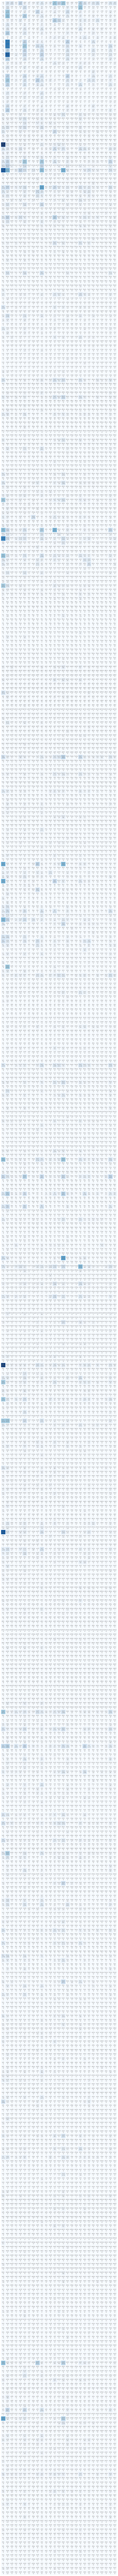

In [99]:
import matplotlib.pyplot as plt
%matplotlib inline

# takes ~35 sec to show
plt.figure(figsize=(16, 300))
plt.imshow(N.numpy(), cmap='Blues')
for g in grams_index.keys():
    for c in chars_index.keys():
        g_i, c_i = grams_index[g], chars_index[c]
        plt.text(c_i, g_i, f"{g}|{c}", ha='center', va='bottom', color='gray')
        plt.text(c_i, g_i, N[g_i, c_i].item(), ha='center', va='top', color='gray')
plt.axis('off')


In [126]:
N1 = N + 1 # model smoothing
N1.shape

P = N1 / N1.sum(dim=1, keepdim=True) # dim=1 to sum over rows
g = torch.Generator().manual_seed(2147483647)

sampled_words = []
for _ in range(30):
    ix_gram = 0 # intial row contains '.a' to '.z'
    gram ='..'
    sampled_word = ''
    while True:
        # probabilities of next character
        p = P[ix_gram]

        # sampling next character
        ix_char = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        sampled_char = chars_index_inverted[ix_char]
        if sampled_char == '.':
            break

        gram = grams_index_inverted[ix_gram][-1] + sampled_char
        sampled_word = sampled_word + sampled_char

        # get gram index
        ix_gram = grams_index[gram]

    sampled_words.append(sampled_word)

sampled_words

['junide',
 'jakasid',
 'prelay',
 'adin',
 'kairritoper',
 'sathen',
 'sameia',
 'yanileniassibduinrwin',
 'lessiyanayla',
 'te',
 'farmumthyfortumj',
 'ponn',
 'lena',
 'jaylicore',
 'ya',
 'jocken',
 'jamilyn',
 'kmikim',
 'yah',
 'sanaasnhavi',
 'monszxhddion',
 'mathani',
 'zie',
 'paun',
 'ty',
 'tin',
 'sreli',
 'ish',
 'dyn',
 'rumel']

In [127]:

n = 0
log_likelihood = 0
for w in words:
    for c1 ,c2, c3 in zip(w, w[1:], w[2:]):
        g = c1+c2
        if c1 == END and c2 == END and c3 == END:
            continue
        p = P[grams_index[g], chars_index[c3]]
        logprob = torch.log(p)
        log_likelihood += logprob
        n += 1
loss = -log_likelihood / n
loss.item()


1.9419735670089722